<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Clean version

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. New loss function.
  - Using modulo and sigmoid
7. Modified R2 score
8. Gene normalization

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'
!pip -q install torcheval
!pip -q install datasets

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
import os
path = Path('data/circadian')

In [5]:
loss_func = F.mse_loss

In [10]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [11]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
metric = R2Score()

In [12]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [13]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

In [14]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [15]:
data = raw_data.set_index('gene').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

#### How should I normalize df with additioanl colums??

Add columns to indicate the column is missing or not.

### Bulk + scRNA-seq

In [16]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [17]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [19]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [20]:
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [21]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = raw_data['gene']

In [22]:
genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [23]:
mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

`df2` is the bulk data used for testing.

In [24]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [25]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [26]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [27]:
df2['code'] = bulk_data['code'].values.astype(float)

<ipython-input-27-4ab7bf0d129f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [28]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df

In [29]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

<ipython-input-28-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


<ipython-input-28-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%
% missing: 47.56666666666667%


<ipython-input-28-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


## Using Pytorch

In [30]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

In [31]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [32]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [33]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [34]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [35]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [36]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl}

Changing the metric to R2Score.

In [37]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [38]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [39]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [40]:
get_model()(xb).shape

torch.Size([128, 1])

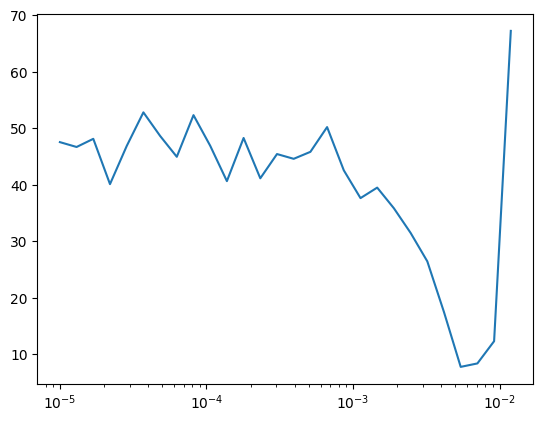

In [41]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.844,7.316,0,True,00:03
0.964,1.675,0,False,00:00
0.980,0.920,1,True,00:03
0.969,1.442,1,False,00:00


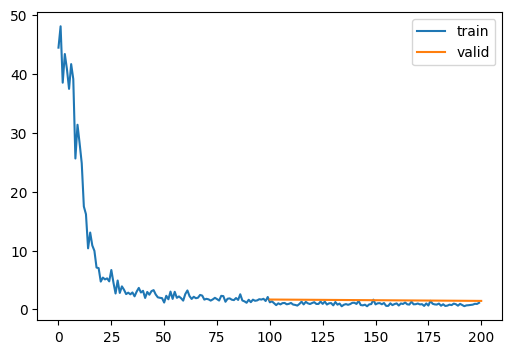

In [42]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [43]:
from functools import partial

In [44]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [45]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [46]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.824,8.239,0,True,00:04
0.965,1.616,0,False,00:00
0.979,0.986,1,True,00:03
0.970,1.386,1,False,00:00


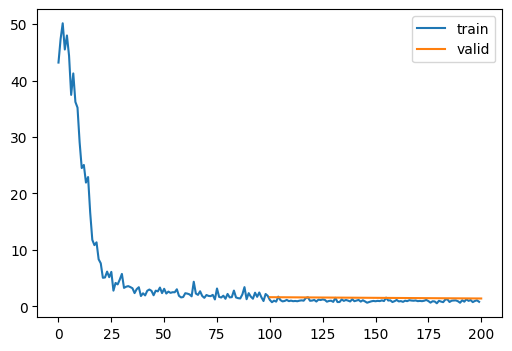

TimeR2Score,loss,epoch,train,time
0.826,8.182,0,True,00:03
0.966,1.648,0,False,00:01
0.980,0.928,1,True,00:04
0.970,1.429,1,False,00:00


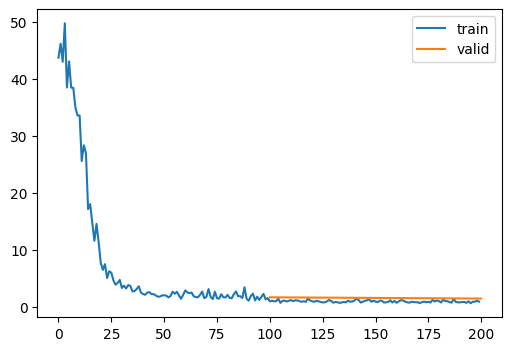

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.754,11.494,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.710,13.556,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.9890,  0.0000],
        [ 6.0666,  4.0000],
        [ 9.8263,  8.0000],
        [10.8710, 12.0000],
        [13.4576, 16.0000],
        [19.4136, 20.0000],
        [ 8.5340,  0.0000],
        [ 2.5354,  4.0000],
        [11.5608,  8.0000],
        [10.5335, 12.0000],
        [19.7833, 16.0000],
        [21.9432, 20.0000]])
result:  tensor(0.7349)


TimeR2Score,loss,epoch,train,time
0.619,18.003,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.700,14.181,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.6871,  1.0000],
        [ 4.2073,  4.0000],
        [ 8.9618,  7.0000],
        [10.0401, 10.0000],
        [13.3782, 13.0000],
        [14.0859, 16.0000],
        [18.9493, 19.0000],
        [19.6154, 22.0000]])
result:  tensor(0.6624)


TimeR2Score,loss,epoch,train,time
0.702,13.886,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.759,11.253,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.9640,  2.0000],
        [ 9.6432,  6.0000],
        [ 9.2111, 10.0000],
        [12.7288, 14.0000],
        [19.3398, 18.0000],
        [20.7746, 22.0000],
        [ 6.9753,  2.0000],
        [ 9.3815,  6.0000],
        [10.9146, 10.0000],
        [12.6055, 14.0000],
        [19.1975, 18.0000],
        [12.9757, 22.0000]])
result:  tensor(0.7332)


In [47]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [48]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [49]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

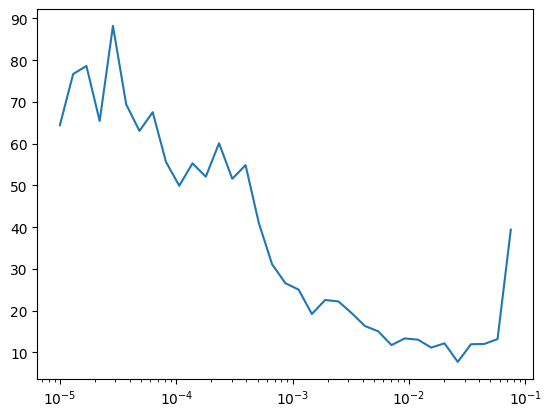

In [50]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.895,5.483,0,True,00:07
0.926,4.216,0,False,00:00
0.941,2.901,1,True,00:04
0.962,2.527,1,False,00:00
0.962,1.853,2,True,00:04
0.970,1.662,2,False,00:01
0.975,1.186,3,True,00:04
0.978,1.259,3,False,00:00


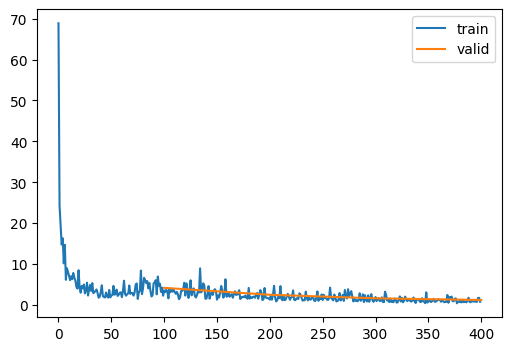

TimeR2Score,loss,epoch,train,time
0.893,5.556,0,True,00:04
0.919,4.232,0,False,00:00
0.936,3.178,1,True,00:05
0.964,1.902,1,False,00:00
0.965,1.684,2,True,00:04
0.978,1.280,2,False,00:00
0.978,1.042,3,True,00:05
0.980,1.162,3,False,00:01


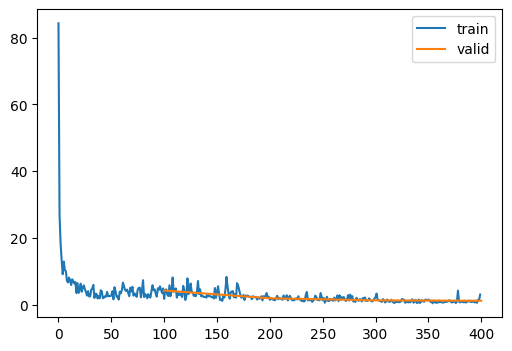

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.722,12.960,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.868,6.165,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 3.0467,  0.0000],
        [ 5.5257,  4.0000],
        [ 7.5850,  8.0000],
        [10.1809, 12.0000],
        [13.5779, 16.0000],
        [18.4926, 20.0000],
        [ 7.1974,  0.0000],
        [ 2.7137,  4.0000],
        [10.8503,  8.0000],
        [10.3574, 12.0000],
        [20.3215, 16.0000],
        [20.4078, 20.0000]])
result:  tensor(0.8101)


TimeR2Score,loss,epoch,train,time
0.875,39.376,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.925,49.278,0,False,00:00


Inference on gro
		preds, targs
tensor([[19.5999,  1.0000],
        [ 4.6117,  4.0000],
        [ 7.4195,  7.0000],
        [ 9.2443, 10.0000],
        [13.6602, 13.0000],
        [15.0046, 16.0000],
        [18.5384, 19.0000],
        [19.9793, 22.0000]])
result:  tensor(0.9047)


TimeR2Score,loss,epoch,train,time
0.869,6.124,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.865,6.318,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.7128,  2.0000],
        [ 7.7088,  6.0000],
        [ 9.5196, 10.0000],
        [13.7439, 14.0000],
        [19.1962, 18.0000],
        [20.9463, 22.0000],
        [ 3.5139,  2.0000],
        [ 8.0082,  6.0000],
        [10.2969, 10.0000],
        [11.5386, 14.0000],
        [20.0708, 18.0000],
        [14.8745, 22.0000]])
result:  tensor(0.8690)


In [51]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.898,5.173,0,True,00:04
0.953,2.529,0,False,00:00
0.954,2.304,1,True,00:04
0.970,1.690,1,False,00:01
0.970,1.480,2,True,00:04
0.978,1.178,2,False,00:00
0.980,0.959,3,True,00:04
0.977,1.237,3,False,00:01


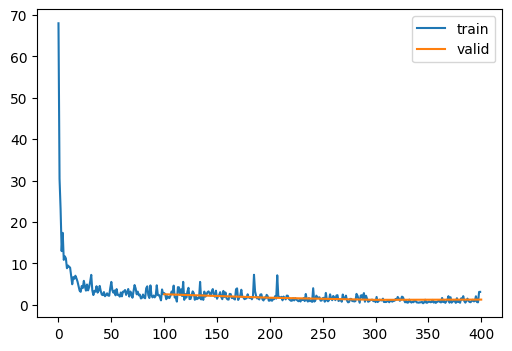

TimeR2Score,loss,epoch,train,time
0.893,5.474,0,True,00:05
0.952,2.869,0,False,00:00
0.945,2.765,1,True,00:04
0.968,1.709,1,False,00:00
0.968,1.514,2,True,00:06
0.975,1.223,2,False,00:00
0.979,0.968,3,True,00:04
0.976,1.206,3,False,00:00


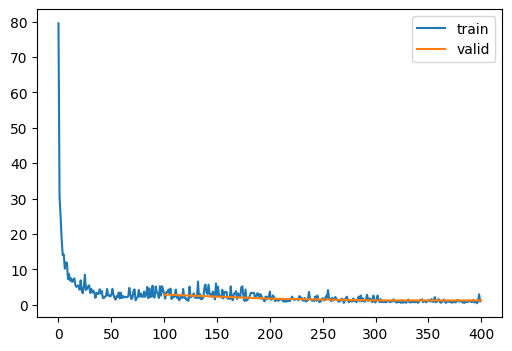

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.875,5.812,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.662,15.754,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.4067,  0.0000],
        [ 5.2414,  4.0000],
        [ 7.1309,  8.0000],
        [ 9.8039, 12.0000],
        [12.7574, 16.0000],
        [18.3795, 20.0000],
        [ 7.9553,  0.0000],
        [ 2.2702,  4.0000],
        [10.8430,  8.0000],
        [10.4117, 12.0000],
        [19.8680, 16.0000],
        [19.8812, 20.0000]])
result:  tensor(0.7894)


TimeR2Score,loss,epoch,train,time
0.909,4.306,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.856,6.783,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 6.6995,  1.0000],
        [ 4.2402,  4.0000],
        [ 7.5398,  7.0000],
        [ 9.6100, 10.0000],
        [13.6689, 13.0000],
        [14.3881, 16.0000],
        [18.3554, 19.0000],
        [19.3537, 22.0000]])
result:  tensor(0.8851)


TimeR2Score,loss,epoch,train,time
0.807,9.009,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.881,5.548,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.0624,  2.0000],
        [ 6.8211,  6.0000],
        [ 9.4302, 10.0000],
        [13.1712, 14.0000],
        [18.7460, 18.0000],
        [20.5659, 22.0000],
        [ 4.0536,  2.0000],
        [ 6.3921,  6.0000],
        [ 9.9594, 10.0000],
        [11.3195, 14.0000],
        [19.5648, 18.0000],
        [14.0074, 22.0000]])
result:  tensor(0.8532)


In [52]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.897,5.312,0,True,00:06
0.893,5.856,0,False,00:00
0.926,3.750,1,True,00:04
0.938,3.275,1,False,00:00
0.948,2.503,2,True,00:05
0.962,1.827,2,False,00:00
0.965,1.652,3,True,00:04
0.975,1.221,3,False,00:00
0.977,1.056,4,True,00:04
0.979,1.077,4,False,00:01


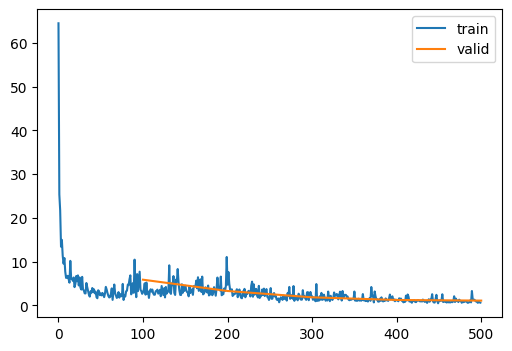

TimeR2Score,loss,epoch,train,time
0.899,5.212,0,True,00:04
0.925,3.863,0,False,00:00
0.921,3.953,1,True,00:04
0.958,2.270,1,False,00:01
0.951,2.413,2,True,00:05
0.968,1.684,2,False,00:00
0.967,1.593,3,True,00:04
0.964,1.874,3,False,00:00
0.980,0.951,4,True,00:05
0.980,1.072,4,False,00:00


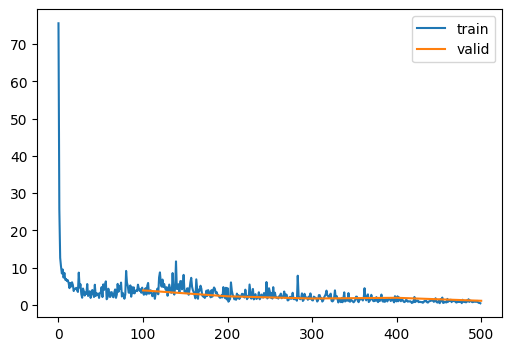

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.864,6.367,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.819,8.459,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.5886,  0.0000],
        [ 5.6843,  4.0000],
        [ 7.3684,  8.0000],
        [10.0618, 12.0000],
        [13.8782, 16.0000],
        [18.6594, 20.0000],
        [ 5.6114,  0.0000],
        [ 2.5034,  4.0000],
        [10.3824,  8.0000],
        [10.3785, 12.0000],
        [21.0382, 16.0000],
        [20.5046, 20.0000]])
result:  tensor(0.8435)


TimeR2Score,loss,epoch,train,time
0.776,10.598,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.757,11.470,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 9.4607,  1.0000],
        [ 4.8744,  4.0000],
        [ 7.7410,  7.0000],
        [ 9.4432, 10.0000],
        [13.6477, 13.0000],
        [13.4365, 16.0000],
        [18.6161, 19.0000],
        [19.5998, 22.0000]])
result:  tensor(0.7722)


TimeR2Score,loss,epoch,train,time
0.909,4.238,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.865,6.288,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.4109,  2.0000],
        [ 7.1180,  6.0000],
        [ 9.4596, 10.0000],
        [13.8476, 14.0000],
        [19.2868, 18.0000],
        [21.4345, 22.0000],
        [ 2.5186,  2.0000],
        [ 7.0562,  6.0000],
        [10.1962, 10.0000],
        [10.7859, 14.0000],
        [19.7749, 18.0000],
        [15.4531, 22.0000]])
result:  tensor(0.8902)


In [59]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.899,5.181,0,True,00:04
0.955,2.322,0,False,00:00
0.950,2.476,1,True,00:04
0.962,2.116,1,False,00:00
0.962,1.774,2,True,00:05
0.974,1.446,2,False,00:00
0.973,1.288,3,True,00:04
0.982,0.850,3,False,00:00
0.982,0.847,4,True,00:04
0.983,0.835,4,False,00:01


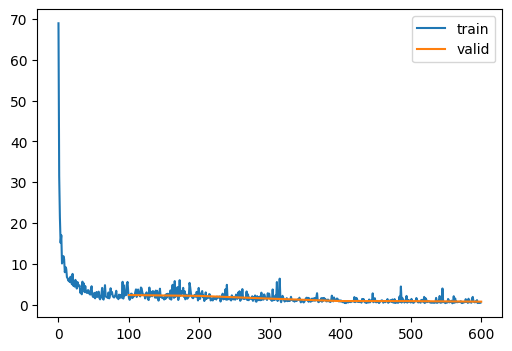

TimeR2Score,loss,epoch,train,time
0.894,5.483,0,True,00:04
0.958,2.152,0,False,00:00
0.948,2.618,1,True,00:05
0.957,2.843,1,False,00:00
0.958,2.052,2,True,00:04
0.973,1.378,2,False,00:00
0.971,1.352,3,True,00:04
0.978,1.290,3,False,00:01
0.980,0.918,4,True,00:04
0.982,1.002,4,False,00:00


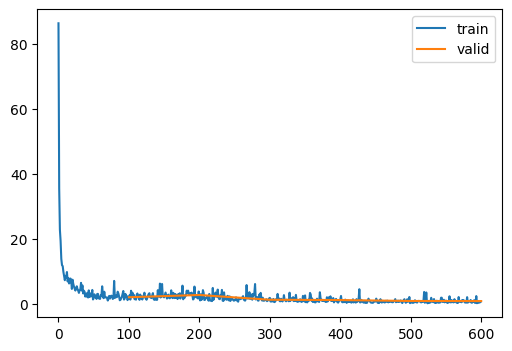

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.850,6.985,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.865,6.313,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.4102,  0.0000],
        [ 6.0192,  4.0000],
        [ 7.1633,  8.0000],
        [10.0487, 12.0000],
        [13.8272, 16.0000],
        [18.1619, 20.0000],
        [ 5.3529,  0.0000],
        [ 3.0950,  4.0000],
        [10.8101,  8.0000],
        [10.3410, 12.0000],
        [20.1017, 16.0000],
        [20.0956, 20.0000]])
result:  tensor(0.8581)


TimeR2Score,loss,epoch,train,time
0.645,23.263,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.792,9.808,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.6395,  1.0000],
        [ 5.3865,  4.0000],
        [ 7.2260,  7.0000],
        [ 9.5652, 10.0000],
        [13.7287, 13.0000],
        [14.1546, 16.0000],
        [18.5986, 19.0000],
        [19.6192, 22.0000]])
result:  tensor(0.6690)


TimeR2Score,loss,epoch,train,time
0.929,3.297,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.928,3.344,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.9967,  2.0000],
        [ 7.2810,  6.0000],
        [ 9.5275, 10.0000],
        [14.0915, 14.0000],
        [18.9756, 18.0000],
        [21.3247, 22.0000],
        [ 3.2749,  2.0000],
        [ 6.7927,  6.0000],
        [10.2181, 10.0000],
        [11.6161, 14.0000],
        [19.6660, 18.0000],
        [17.4185, 22.0000]])
result:  tensor(0.9357)


In [54]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.